# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [6]:
transforms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

In [32]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/saint_bernard_188.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_114.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Persian_144.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Maine_Coon_268.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/pug_161.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_175.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/basset_hound_125.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_133.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/keeshond_114.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/great_pyrenees_104.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-

In [9]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(transforms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(224, bs, 'zeros')

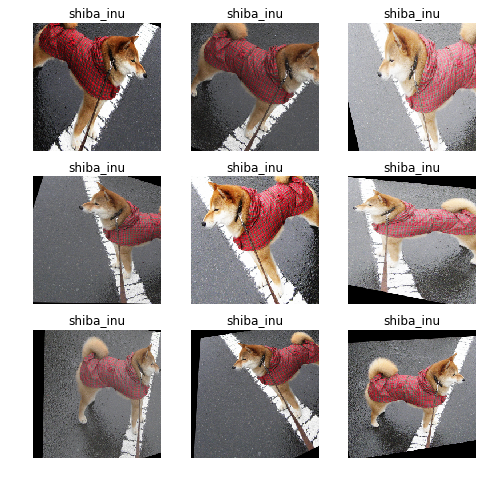

In [14]:
def _plot(i,j,ax):
    x,y = data.train_ds[42]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [15]:
data = get_data(224,bs)

In [23]:
doc(ImageDataBunch)

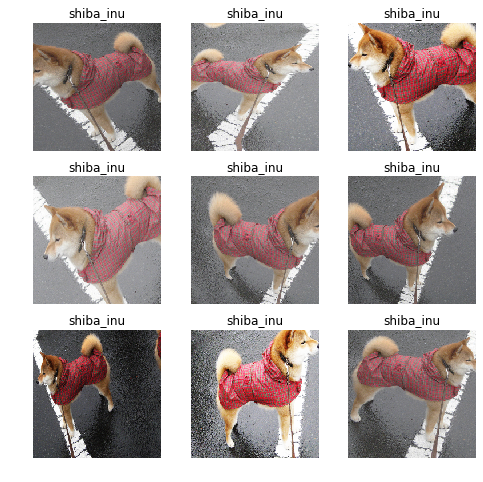

In [33]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [34]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [35]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.574018,1.386510,0.296346,01:16
1,1.534311,0.361177,0.085250,01:07
2,0.912427,0.286202,0.077808,01:08


In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.689117,0.297534,0.069012,01:12
1,0.673793,0.280133,0.058863,01:11


In [38]:
data = get_data(352,bs)
learn.data = data

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.622680,0.281973,0.054804,02:34
1,0.594581,0.275956,0.052774,02:28


In [40]:
learn.save('352')

## Convolution kernel

In [41]:
data = get_data(352,16)

In [42]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [149]:
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

Category american_pit_bull_terrier

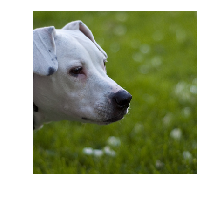

In [197]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [198]:
k = tensor([
    [4., 4, 4],
    [0., 0, 0],
    [-2., -2 ,-2.],
]).expand(1,3,3,3)/6

In [199]:
k

tensor([[[[ 0.6667,  0.6667,  0.6667],
          [ 0.0000,  0.0000,  0.0000],
          [-0.3333, -0.3333, -0.3333]],

         [[ 0.6667,  0.6667,  0.6667],
          [ 0.0000,  0.0000,  0.0000],
          [-0.3333, -0.3333, -0.3333]],

         [[ 0.6667,  0.6667,  0.6667],
          [ 0.0000,  0.0000,  0.0000],
          [-0.3333, -0.3333, -0.3333]]]])

In [200]:
k.shape

torch.Size([1, 3, 3, 3])

In [201]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [202]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [203]:
edge = F.conv2d(t[None], k)

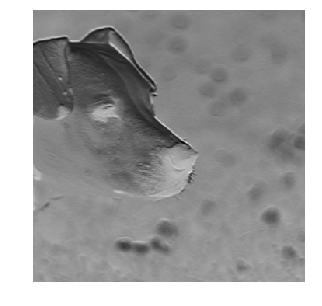

In [204]:
show_image(edge[0], figsize=(5,5));

In [158]:
data.c

37

In [159]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [160]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [205]:
m = learn.model.eval();

In [206]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [207]:
from fastai.callbacks.hooks import *

In [208]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [209]:
hook_a,hook_g = hooked_backward()

In [210]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [211]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [212]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

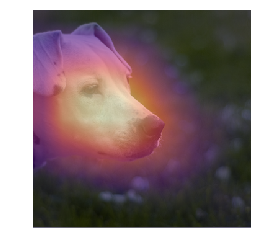

In [213]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [171]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [172]:
mult = (acts*grad_chan[...,None,None]).mean(0)

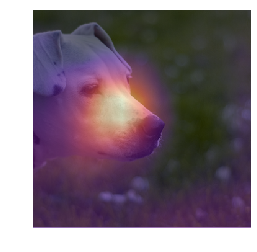

In [173]:
show_heatmap(mult)

In [131]:
fn = path/'../other/doge.jpg' #Replace with your own image

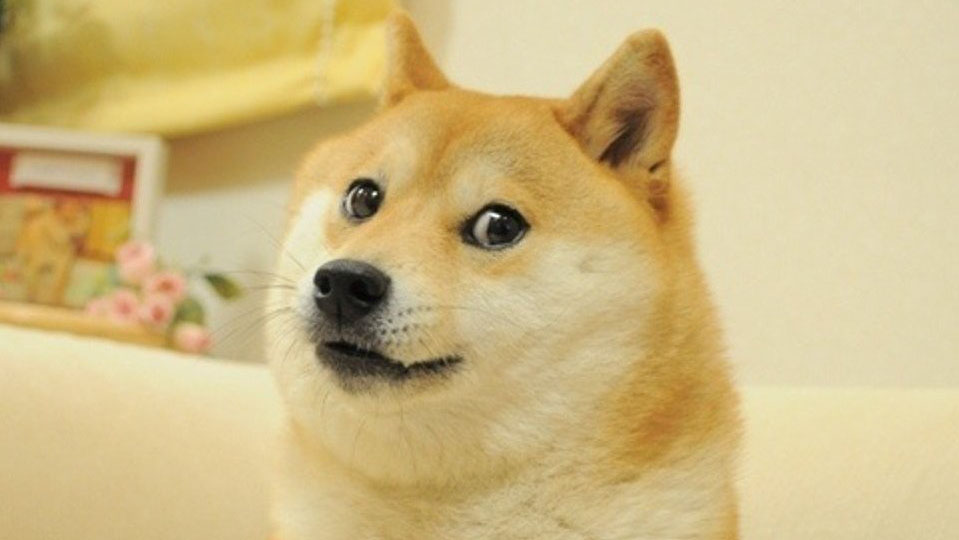

In [174]:
x = open_image(fn); x

In [175]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [176]:
hook_a,hook_g = hooked_backward()

In [177]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

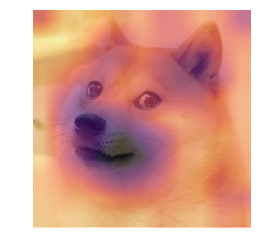

In [136]:
show_heatmap(mult)

In [182]:
data.classes[0]

'Abyssinian'

In [189]:
hook_a,hook_g = hooked_backward(0)

In [194]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

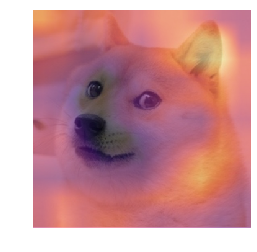

In [195]:
show_heatmap(mult)

## fin